In [1]:
import numpy as np
import cv2 as cv
import scipy
import kornia
import torch
import matplotlib
import matplotlib.pyplot as plt
import skimage
from PIL import Image



In [2]:
# Reading and opening images
i1 = cv.imread('parliament-left.jpg') 
i2 = cv.imread('parliament-right.jpg')


img1_raw = Image.open('parliament-left.jpg') 
img2_raw = Image.open('parliament-right.jpg')

target_size = img2_raw.size
img1_raw = img1_raw.crop((0, 0, target_size[0], target_size[1]))

img1_raw = np.array(img1_raw)
img2_raw = np.array(img2_raw)


img1_gray = cv.cvtColor(img1_raw, cv.COLOR_BGR2GRAY)
img2_gray = cv.cvtColor(img2_raw, cv.COLOR_BGR2GRAY)


In [3]:
# detecting keypoints for img1
sift = cv.SIFT_create()
kp = sift.detect(img1_gray, None)
img1 = cv.drawKeypoints(img1_gray, kp, img1_raw)
cv.imwrite('sift_keypoints1.jpg', img1)

img1=cv.drawKeypoints(img1_gray,kp,img1,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv.imwrite('sift_keypoints1.jpg',img1)

# detecting keypoints for img2
sift = cv.SIFT_create()
kp = sift.detect(img2_gray, None)
img2 = cv.drawKeypoints(img2_gray, kp, img2_raw)
cv.imwrite('sift_keypoints2.jpg', img2)

img2=cv.drawKeypoints(img2_gray,kp,img2,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv.imwrite('sift_keypoints2.jpg',img2)

True

In [4]:
# calculating descriptors for img1
sift = cv.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1_gray, None)

# calculating descriptor for img2
kp2, des2 = sift.detectAndCompute(img2_gray, None)

In [5]:
# convert descriptors to tensors
des1_tensor = torch.from_numpy(des1)
des2_tensor = torch.from_numpy(des2)

distances, idx = kornia.feature.match_snn(des1_tensor, des2_tensor, 0.4)


In [6]:
# make an array from the keypoints
arr = []
for i in range(len(idx)):
    arr.append(kp1[idx[i][0]].pt[0])
    arr.append(kp1[idx[i][0]].pt[1])    
    arr.append(kp2[idx[i][1]].pt[0])
    arr.append(kp2[idx[i][1]].pt[1])

In [7]:
arr = np.array(arr)
arr = arr.reshape((-1, 4))
print(arr)

[[1469.15539551  728.67498779   12.41187859  593.28094482]
 [1469.15539551  728.67498779   12.41187859  593.28094482]
 [1469.69421387  734.32177734   12.75405121  598.87457275]
 ...
 [2258.50146484 1330.08654785  753.81170654 1222.12133789]
 [2259.23754883 2159.11376953  712.01751709 2033.11877441]
 [2259.29980469 1494.32617188  746.25695801 1382.85253906]]


In [8]:
# Provided code for plotting inlier matches between two images

def plot_inlier_matches(ax, img1, img2, inliers):
    """
    Plot the matches between two images according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :inliers: x,y in the first image and x,y in the second image (Nx4)
    """
    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')

    
    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2] + img1.shape[1], inliers[:,3], '+r')
    ax.plot([inliers[:,0], inliers[:,2] + img1.shape[1]],
            [inliers[:,1], inliers[:,3]], 'r', linewidth=0.4)
    ax.axis('off')

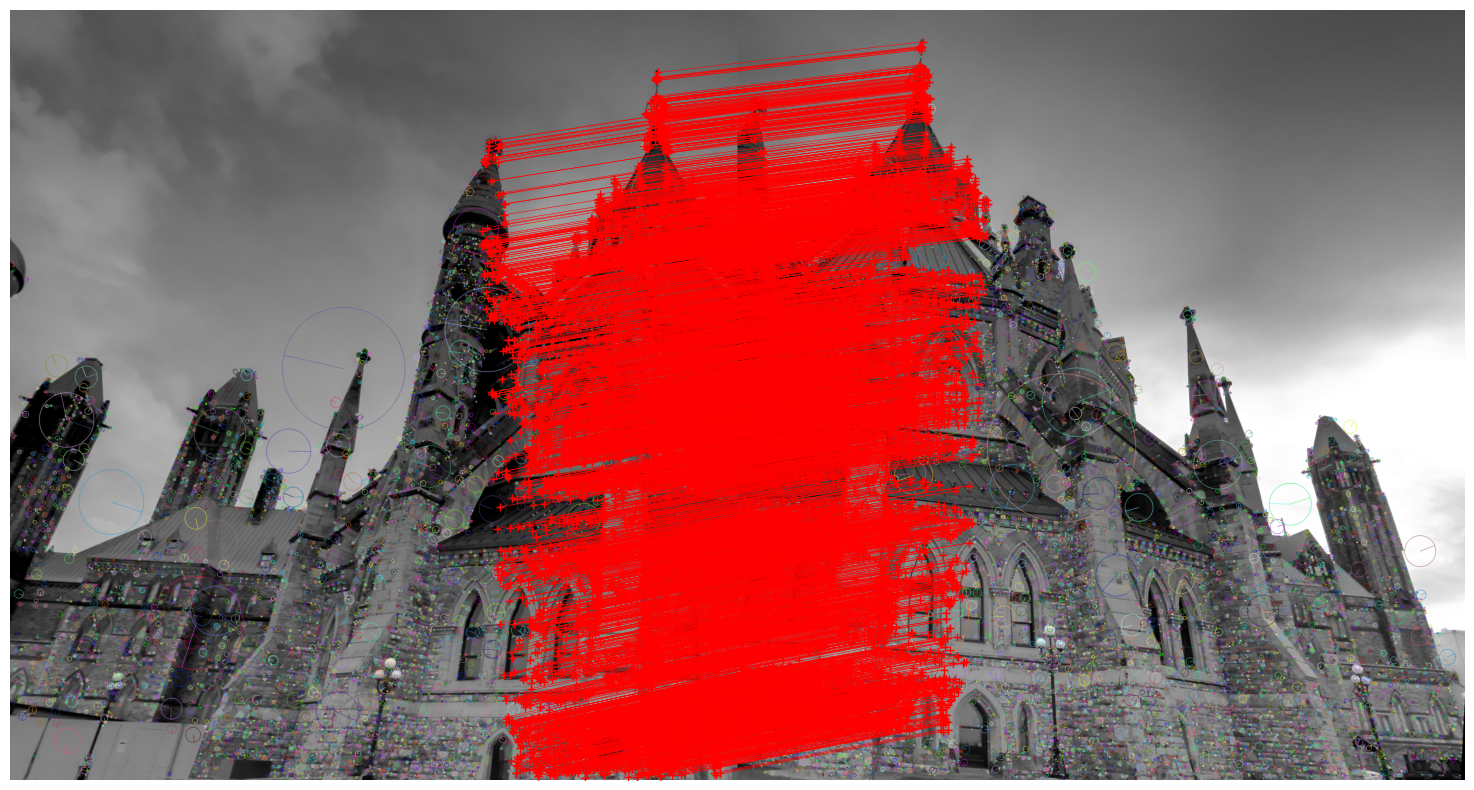

In [9]:
# Usage:
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, img1_raw, img2_raw, arr)

In [10]:
arr1 = arr
arr1 = arr1.reshape(-1, 2)
print(len(arr1))



9490


In [11]:
# segregate the points to 2 arrays for each image
img1_arr2 = []
img2_arr3 = []
for i in range(len(arr1)):
    if i % 2 == 0:
        img1_arr2.append(arr1[i])
    else:
        img2_arr3.append(arr1[i])

In [12]:
# min number of pairwise matches used: 3
# RANSAC
max = 0
most_inliers = []

for i in range(100):
    # 3 points from img 1
    m1 = []
    one = np.random.choice(range(len(img1_arr2)))
    two = np.random.choice(range(len(img1_arr2)))
    three = np.random.choice(range(len(img1_arr2)))
    
    m1.append([img1_arr2[one][0], img1_arr2[one][1], 1])
    m1.append([img1_arr2[two][0], img1_arr2[two][1], 1])
    m1.append([img1_arr2[three][0], img1_arr2[three][1], 1])
    
    m2 = []
    m2.append([img2_arr3[one][0], img2_arr3[one][1], 1])
    m2.append([img2_arr3[two][0], img2_arr3[two][1], 1])
    m2.append([img2_arr3[three][0], img2_arr3[three][1], 1])

    m3 = np.matmul(np.linalg.inv(m1), m2)
    m3 = np.transpose(m3)

    temp_inliers = []
    counter = 0
    for j in range(len(img1_arr2)):

        
        arr5 = []
        arr5.append([img1_arr2[j][0], img1_arr2[j][1], 1])
        arr5 = np.transpose(arr5)
        a, b = [img1_arr2[j][0], img1_arr2[j][1]]
        
        x,y,z = np.matmul(m3, arr5)
        
        dis = np.sqrt((x - img2_arr3[j][0])*(x - img2_arr3[j][0]) + (y - img2_arr3[j][1])*(y - img2_arr3[j][1]))

        
        if dis < 0.01:
            temp_inliers.append([a, b, img2_arr3[j][0], img2_arr3[j][1]])
            counter += 1
    if counter > max:
        max = counter
        most_inliers = temp_inliers


In [13]:
A = []
b = []
for i in range(len(most_inliers)):
    A.append([most_inliers[i][0], most_inliers[i][1], 1])
    b.append([most_inliers[i][2], most_inliers[i][3], 1])

In [14]:
# Transformation
x = np.matmul(np.matmul(np.linalg.inv(np.matmul(np.transpose(A), A)), np.transpose(A)), b)

In [15]:
print(x)

[[ 9.78554424e-01  5.12170952e-02 -3.25260652e-18]
 [-5.12246052e-02  9.78342176e-01 -1.35525272e-19]
 [-1.38802912e+03 -1.94941382e+02  1.00000000e+00]]


In [16]:
x = np.transpose(x)

In [17]:
a = skimage.transform.ProjectiveTransform(x)

In [18]:
# skimage.transform.ProjectiveTransform and skimage.transform.warp

In [19]:
b = skimage.transform.warp(img2_raw, a, output_shape=(2500,4000))

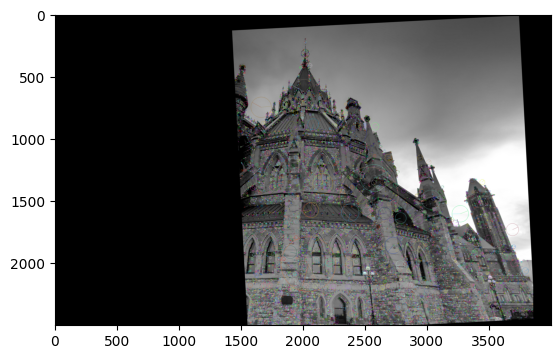

In [20]:
plt.imshow(b)

In [21]:
# combining the 2 images
img1_raw = img1_raw/255.0
for i in range(3):
    b[:img1_raw.shape[0], :img1_raw.shape[1]] = np.maximum(b[:img1_raw.shape[0], :img1_raw.shape[1]], img1_raw[:img1_raw.shape[0], :img1_raw.shape[1]]) 

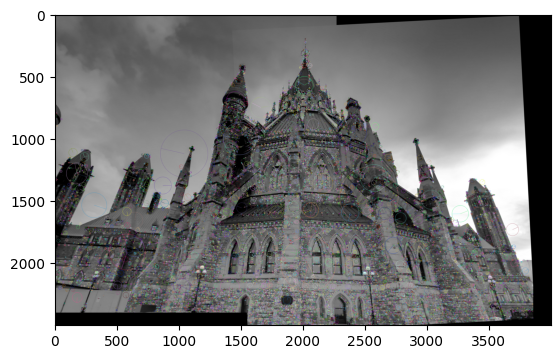

In [22]:
plt.imshow(b)

In [23]:
# ---------------------------------------------------------- PART B ----------------------------------------------------------

In [69]:
# reading and opening images
glendon_left_raw = Image.open('Glendon-Hall-left.jpg') 
glendon_middle_raw = Image.open('Glendon-Hall-middle.jpg')
glendon_right_raw = Image.open('Glendon-Hall-right.jpg')


glendon_left_c = np.array(glendon_left_raw)
glendon_middle_c = np.array(glendon_middle_raw)
glendon_right_c = np.array(glendon_right_raw)


glendon_left = np.array(glendon_left_raw)
glendon_middle = np.array(glendon_middle_raw)
glendon_right = np.array(glendon_right_raw)


glendon_left_gray = cv.cvtColor(glendon_left, cv.COLOR_BGR2GRAY)
glendon_middle_gray = cv.cvtColor(glendon_middle, cv.COLOR_BGR2GRAY)
glendon_right_gray = cv.cvtColor(glendon_right, cv.COLOR_BGR2GRAY)



In [70]:
# detecing keypoints for each image

sift = cv.SIFT_create()

# left img
kp1 = sift.detect(glendon_left_gray, None)
left = cv.drawKeypoints(glendon_left_gray, kp1, glendon_left)
cv.imwrite('sift_keypoints1.jpg', left)
left=cv.drawKeypoints(glendon_left_gray,kp1,left,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv.imwrite('sift_keypoints1.jpg',left)


kp2 = sift.detect(glendon_middle_gray, None)
middle = cv.drawKeypoints(glendon_middle_gray, kp2, glendon_middle)
cv.imwrite('sift_keypoints2.jpg', middle)
middle=cv.drawKeypoints(glendon_middle_gray,kp2,middle,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv.imwrite('sift_keypoints2.jpg',middle)


kp3 = sift.detect(glendon_right_gray, None)
right = cv.drawKeypoints(glendon_right_gray, kp3, glendon_right)
cv.imwrite('sift_keypoints3.jpg', right)
right=cv.drawKeypoints(glendon_right_gray,kp3,right,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv.imwrite('sift_keypoints3.jpg',right)

True

In [71]:
# sorting the keypoints to get just the top important ones 
# because there are a lot of keypoints so it was giving an error since it can't handle that many

kp1 = sorted(kp1, key=lambda x: x.response, reverse=True)
kp2 = sorted(kp2, key=lambda x: x.response, reverse=True)
kp3 = sorted(kp3, key=lambda x: x.response, reverse=True)

In [72]:
# Getting the first 10000 keypoints for each image
kp1 = kp1[0: 10000]
kp2 = kp2[0: 10000]
kp3 = kp3[0: 10000]

In [73]:
# Calculating descriptors for each image
kp1, des1 = sift.compute(glendon_left_gray, kp1)
kp2, des2 = sift.compute(glendon_middle_gray, kp2)
kp3, des3 = sift.compute(glendon_right_gray, kp3)


In [74]:
# converting descriptors to tensors
des1_tensor = torch.tensor(des1)
des2_tensor = torch.tensor(des2)
des3_tensor = torch.tensor(des3)

In [75]:
distances1, idx1 = kornia.feature.match_snn(des1_tensor, des2_tensor, 0.4)
distances2, idx2 = kornia.feature.match_snn(des2_tensor, des3_tensor, 0.4)

In [76]:
arr1 = []
for i in range(len(idx1)):
    arr1.append(kp1[idx1[i][0]].pt[0])
    arr1.append(kp1[idx1[i][0]].pt[1])    
    arr1.append(kp2[idx1[i][1]].pt[0])
    arr1.append(kp2[idx1[i][1]].pt[1])


arr2 = []
for i in range(len(idx2)):
    arr2.append(kp2[idx2[i][0]].pt[0])
    arr2.append(kp2[idx2[i][0]].pt[1])    
    arr2.append(kp3[idx2[i][1]].pt[0])
    arr2.append(kp3[idx2[i][1]].pt[1])

In [77]:
arr1 = np.array(arr1)
arr1 = arr1.reshape((-1, 4))

In [78]:
arr2 = np.array(arr2)
arr2 = arr2.reshape((-1, 4))

In [79]:
# Provided code for plotting inlier matches between two images

def plot_inlier_matches(ax, img1, img2, inliers):
    """
    Plot the matches between two images according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :inliers: x,y in the first image and x,y in the second image (Nx4)
    """
    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')

    
    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2] + img1.shape[1], inliers[:,3], '+r')
    ax.plot([inliers[:,0], inliers[:,2] + img1.shape[1]],
            [inliers[:,1], inliers[:,3]], 'r', linewidth=0.4)
    ax.axis('off')

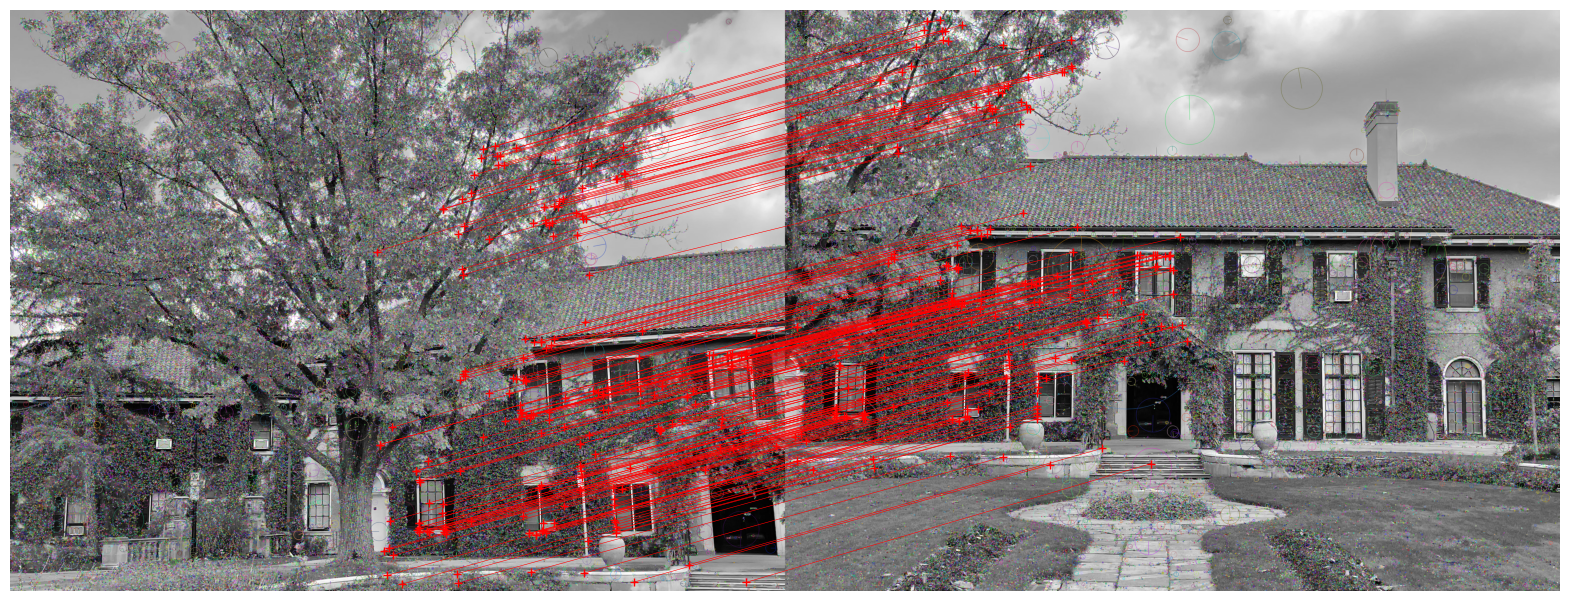

In [80]:
# Usage:
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, glendon_left, glendon_middle, arr1)

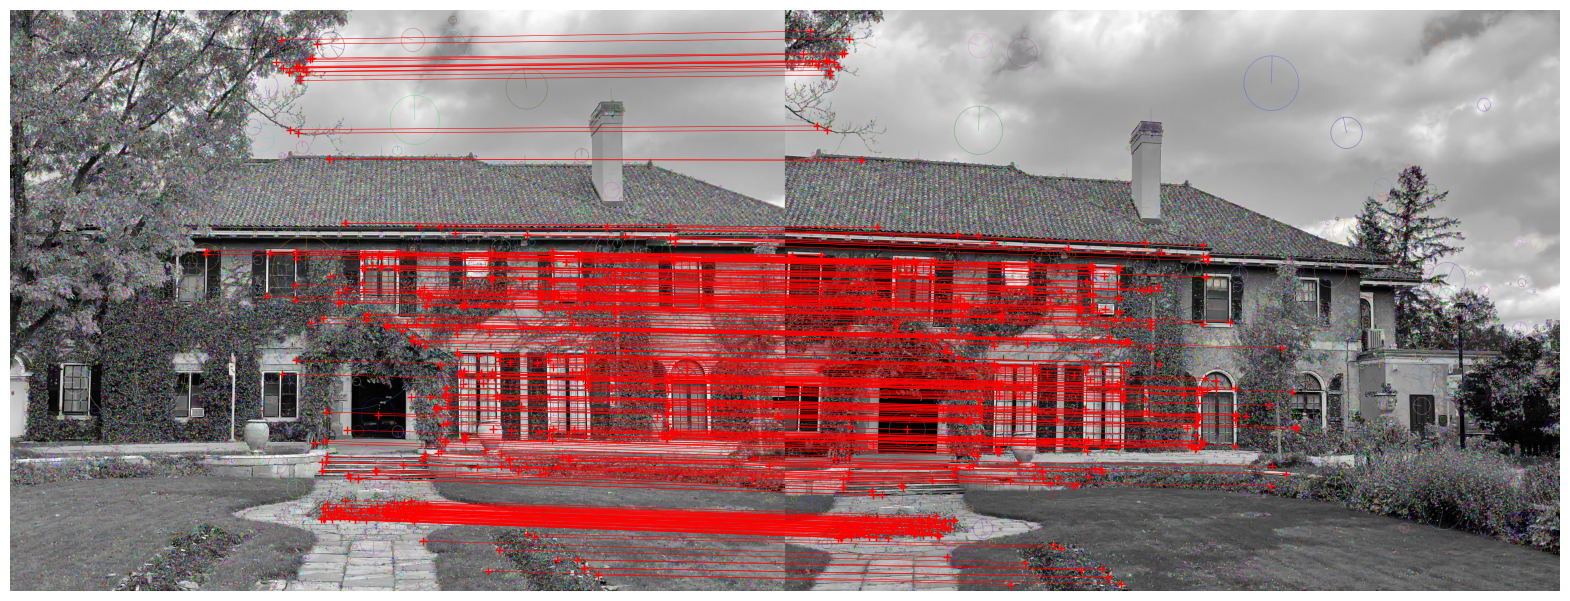

In [81]:
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, glendon_middle, glendon_right, arr2)

In [82]:
arr11 = arr1
arr11 = arr11.reshape(-1, 2)
print(len(arr11))

424


In [83]:
arr22 = arr2
arr22 = arr22.reshape(-1, 2)
print(len(arr22))

892


In [84]:
glendon_left_arr = []
glendon_middle_arr1 = []
for i in range(len(arr11)):
    if i % 2 == 0:
        glendon_left_arr.append(arr11[i])
    else:
        glendon_middle_arr1.append(arr11[i])

In [85]:
glendon_middle_arr2 = []
glendon_right_arr = []
for i in range(len(arr22)):
    if i % 2 == 0:
        glendon_middle_arr2.append(arr22[i])
    else:
        glendon_right_arr.append(arr22[i])

In [86]:
# Finding most inliers between glendon_left and glendon_middle
max1 = 0
most_inliers1 = []

for i in range(100):
    m = []
    one = np.random.choice(range(len(glendon_left_arr)))
    two = np.random.choice(range(len(glendon_left_arr)))
    three = np.random.choice(range(len(glendon_left_arr)))
    four = np.random.choice(range(len(glendon_left_arr)))
    
    m.append([glendon_left_arr[one][0], glendon_left_arr[one][1], 1, 0, 0, 0, -(glendon_left_arr[one][0] * glendon_middle_arr1[one][0]), -(glendon_left_arr[one][1] * glendon_middle_arr1[one][0]), -glendon_middle_arr1[one][0]])
    m.append([0, 0, 0, glendon_left_arr[one][0], glendon_left_arr[one][1], 1, -(glendon_left_arr[one][0] * glendon_middle_arr1[one][1]), -(glendon_left_arr[one][1] * glendon_middle_arr1[one][1]), -glendon_middle_arr1[one][1]])
    
    m.append([glendon_left_arr[two][0], glendon_left_arr[two][1], 1, 0, 0, 0, -(glendon_left_arr[two][0] * glendon_middle_arr1[two][0]), -(glendon_left_arr[two][1] * glendon_middle_arr1[two][0]), -glendon_middle_arr1[two][0]])
    m.append([0, 0, 0, glendon_left_arr[two][0], glendon_left_arr[two][1], 1, -(glendon_left_arr[two][0] * glendon_middle_arr1[two][1]), -(glendon_left_arr[two][1] * glendon_middle_arr1[two][1]), -glendon_middle_arr1[two][1]])

    m.append([glendon_left_arr[three][0], glendon_left_arr[three][1], 1, 0, 0, 0, -(glendon_left_arr[three][0] * glendon_middle_arr1[three][0]), -(glendon_left_arr[three][1] * glendon_middle_arr1[three][0]), -glendon_middle_arr1[three][0]])
    m.append([0, 0, 0, glendon_left_arr[three][0], glendon_left_arr[three][1], 1, -(glendon_left_arr[three][0] * glendon_middle_arr1[three][1]), -(glendon_left_arr[three][1] * glendon_middle_arr1[three][1]), -glendon_middle_arr1[three][1]])

    m.append([glendon_left_arr[four][0], glendon_left_arr[four][1], 1, 0, 0, 0, -(glendon_left_arr[four][0] * glendon_middle_arr1[four][0]), -(glendon_left_arr[four][1] * glendon_middle_arr1[four][0]), -glendon_middle_arr1[four][0]])
    m.append([0, 0, 0, glendon_left_arr[four][0], glendon_left_arr[four][1], 1, -(glendon_left_arr[four][0] * glendon_middle_arr1[four][1]), -(glendon_left_arr[four][1] * glendon_middle_arr1[four][1]), -glendon_middle_arr1[four][1]])    


    rows = np.array(m)
    U, D, V = np.linalg.svd(rows)
    H = V[-1].reshape(3,3)

    temp_inliers = []
    counter = 0
    for j in range(len(glendon_left_arr)):
        
        new_arr = []
        new_arr.append([glendon_left_arr[j][0], glendon_left_arr[j][1], 1])
        new_arr = np.transpose(new_arr)
        a, b = [glendon_left_arr[j][0], glendon_left_arr[j][1]]

        x,y,z = np.matmul(H, new_arr)
        x = x/z
        y = y/z
        
        dis = np.sqrt((x - glendon_middle_arr1[j][0])*(x - glendon_middle_arr1[j][0]) + (y - glendon_middle_arr1[j][1])*(y - glendon_middle_arr1[j][1]))
 
        if dis < 0.01:
            temp_inliers.append([a, b, glendon_middle_arr1[j][0], glendon_middle_arr1[j][1]])
            counter += 1
    if counter > max1:
        max1 = counter
        most_inliers1 = temp_inliers


In [87]:
# Finding most inliers between glendon_middle and glendon_right
max2 = 0
most_inliers2 = []

for i in range(100):
    m2 = []
    one = np.random.choice(range(len(glendon_middle_arr2)))
    two = np.random.choice(range(len(glendon_middle_arr2)))
    three = np.random.choice(range(len(glendon_middle_arr2)))
    four = np.random.choice(range(len(glendon_middle_arr2)))
    
    m2.append([glendon_middle_arr2[one][0], glendon_middle_arr2[one][1], 1, 0, 0, 0, -(glendon_middle_arr2[one][0] * glendon_right_arr[one][0]), -(glendon_middle_arr2[one][1] * glendon_right_arr[one][0]), -glendon_right_arr[one][0]])
    m2.append([0, 0, 0, glendon_middle_arr2[one][0], glendon_middle_arr2[one][1], 1, -(glendon_middle_arr2[one][0] * glendon_right_arr[one][1]), -(glendon_middle_arr2[one][1] * glendon_right_arr[one][1]), -glendon_right_arr[one][1]])
    
    m2.append([glendon_middle_arr2[two][0], glendon_middle_arr2[two][1], 1, 0, 0, 0, -(glendon_middle_arr2[two][0] * glendon_right_arr[two][0]), -(glendon_middle_arr2[two][1] * glendon_right_arr[two][0]), -glendon_right_arr[two][0]])
    m2.append([0, 0, 0, glendon_middle_arr2[two][0], glendon_middle_arr2[two][1], 1, -(glendon_middle_arr2[two][0] * glendon_right_arr[two][1]), -(glendon_middle_arr2[two][1] * glendon_right_arr[two][1]), -glendon_right_arr[two][1]])

    m2.append([glendon_middle_arr2[three][0], glendon_middle_arr2[three][1], 1, 0, 0, 0, -(glendon_middle_arr2[three][0] * glendon_right_arr[three][0]), -(glendon_middle_arr2[three][1] * glendon_right_arr[three][0]), -glendon_right_arr[three][0]])
    m2.append([0, 0, 0, glendon_middle_arr2[three][0], glendon_middle_arr2[three][1], 1, -(glendon_middle_arr2[three][0] * glendon_right_arr[three][1]), -(glendon_middle_arr2[three][1] * glendon_right_arr[three][1]), -glendon_right_arr[three][1]])

    m2.append([glendon_middle_arr2[four][0], glendon_middle_arr2[four][1], 1, 0, 0, 0, -(glendon_middle_arr2[four][0] * glendon_right_arr[four][0]), -(glendon_middle_arr2[four][1] * glendon_right_arr[four][0]), -glendon_right_arr[four][0]])
    m2.append([0, 0, 0, glendon_middle_arr2[four][0], glendon_middle_arr2[four][1], 1, -(glendon_middle_arr2[four][0] * glendon_right_arr[four][1]), -(glendon_middle_arr2[four][1] * glendon_right_arr[four][1]), -glendon_right_arr[four][1]])    


    rows2 = np.array(m2)
    U, D, V = np.linalg.svd(rows2)
    H = V[-1].reshape(3,3)

    temp_inliers = []
    counter = 0
    for j in range(len(glendon_middle_arr2)):
        
        new_arr = []
        new_arr.append([glendon_middle_arr2[j][0], glendon_middle_arr2[j][1], 1])
        new_arr = np.transpose(new_arr)
        a, b = [glendon_middle_arr2[j][0], glendon_middle_arr2[j][1]]

        x,y,z = np.matmul(H, new_arr)
        x = x/z
        y = y/z
        
        dis = np.sqrt((x - glendon_right_arr[j][0])*(x - glendon_right_arr[j][0]) + (y - glendon_right_arr[j][1])*(y - glendon_right_arr[j][1]))
 
        if dis < 0.01:
            temp_inliers.append([a, b, glendon_right_arr[j][0], glendon_right_arr[j][1]])
            counter += 1
    if counter > max2:
        max2 = counter
        most_inliers2 = temp_inliers


In [88]:
A1 = []
for i in range(len(most_inliers1)):
    x1 = most_inliers1[i][0]
    y1 = most_inliers1[i][1]
    x2 = most_inliers1[i][2]
    y2 = most_inliers1[i][3]
    A1.append([x1, y1, 1, 0, 0, 0, -x1*x2, -y1*x2, -x2])
    A1.append([0, 0, 0, x1, y1, 1, -x1*y2, -y1*y2, -y2])

In [89]:
A2 = []
for i in range(len(most_inliers2)):
    x1 = most_inliers2[i][0]
    y1 = most_inliers2[i][1]
    x2 = most_inliers2[i][2]
    y2 = most_inliers2[i][3]
    A2.append([x1, y1, 1, 0, 0, 0, -x1*x2, -y1*x2, -x2])
    A2.append([0, 0, 0, x1, y1, 1, -x1*y2, -y1*y2, -y2])

In [90]:
U1, D1, V1 = np.linalg.svd(A1)
H1 = V1[-1].reshape(3, 3)

In [91]:
U2, D2, V2 = np.linalg.svd(A2)
H2 = V2[-1].reshape(3, 3)

In [92]:
a1 = skimage.transform.ProjectiveTransform(H1)

In [93]:
a2 = skimage.transform.ProjectiveTransform(H2)

In [94]:
b1 = skimage.transform.warp(glendon_middle_c, a1, output_shape=(4024,8032))

In [95]:
b2 = skimage.transform.warp(glendon_right_c, a2, output_shape=(4024,8032))

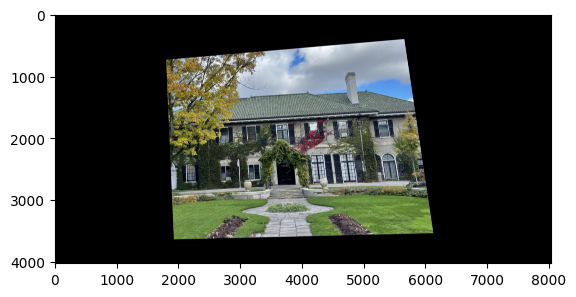

In [96]:
plt.imshow(b1)

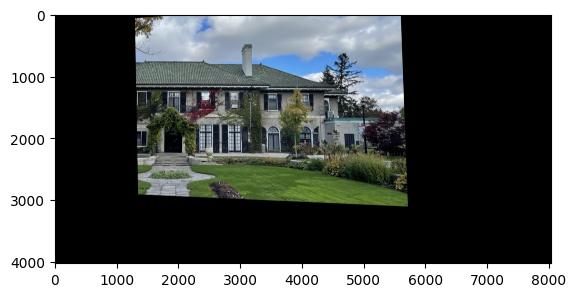

In [97]:
plt.imshow(b2)

In [98]:
glendon_left_c = glendon_left_c/255.0

In [99]:
glendon_left_c

array([[[0.27843137, 0.52941176, 0.90980392],
        [0.27843137, 0.52941176, 0.90980392],
        [0.27843137, 0.52941176, 0.90980392],
        ...,
        [0.6745098 , 0.7372549 , 0.86666667],
        [0.67843137, 0.74117647, 0.87058824],
        [0.67843137, 0.74117647, 0.87058824]],

       [[0.27843137, 0.52941176, 0.90980392],
        [0.27843137, 0.52941176, 0.90980392],
        [0.27843137, 0.52941176, 0.90980392],
        ...,
        [0.67843137, 0.74117647, 0.87058824],
        [0.67843137, 0.74117647, 0.87058824],
        [0.67843137, 0.74117647, 0.87058824]],

       [[0.27843137, 0.52941176, 0.90980392],
        [0.27843137, 0.52941176, 0.90980392],
        [0.27843137, 0.52941176, 0.90980392],
        ...,
        [0.67843137, 0.74117647, 0.87058824],
        [0.68235294, 0.74509804, 0.8745098 ],
        [0.68235294, 0.74509804, 0.8745098 ]],

       ...,

       [[0.70588235, 0.70588235, 0.69803922],
        [0.68627451, 0.68627451, 0.67843137],
        [0.66666667, 0

In [100]:
for i in range(3):
    b1[:glendon_left_c.shape[0], :glendon_left_c.shape[1]] = np.maximum(b1[:glendon_left_c.shape[0], :glendon_left_c.shape[1]], glendon_left_c[:glendon_left_c.shape[0], :glendon_left_c.shape[1]]) 


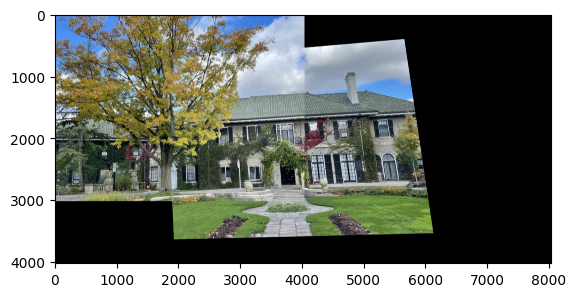

In [101]:
plt.imshow(b1)

In [102]:
glendon_middle_c = glendon_middle_c/255.0

In [103]:
for i in range(3):
    b2[:glendon_middle_c.shape[0], :glendon_middle_c.shape[1]] = np.maximum(b2[:glendon_middle_c.shape[0], :glendon_middle_c.shape[1]], glendon_middle_c[:glendon_middle_c.shape[0], :glendon_middle_c.shape[1]]) 


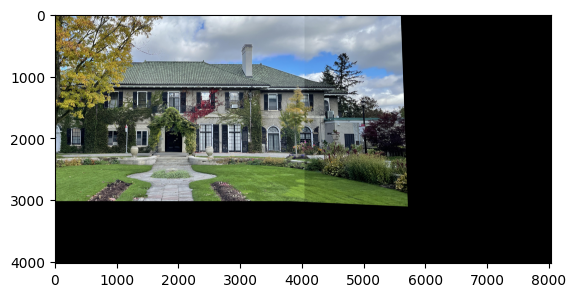

In [104]:
plt.imshow(b2)

In [105]:
# -------------------------COMBINING THE LEFT COMBINATION AND THE RIGHT COMBINATION OF IMAGES---------------------------------

In [106]:
b222 = b2
a111 = a1

In [107]:
b3 = skimage.transform.warp(b222, a111, output_shape=(5024,10032))

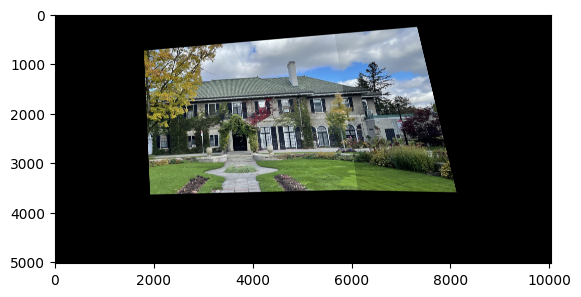

In [108]:
plt.imshow(b3)


In [109]:
for i in range(3):
    	b3[:glendon_left_c.shape[0], :glendon_left_c.shape[1]] = 	np.maximum(b3[:glendon_left_c.shape[0], :glendon_left_c.shape[1]], 	glendon_left_c[:glendon_left_c.shape[0], :glendon_left_c.shape[1]]) 





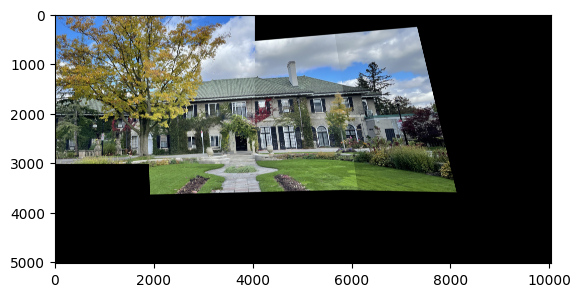

In [110]:
plt.imshow(b3)